In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import random
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from parse_dataset import NetworkDataset, parse_dataset, split_datasets

In [2]:
conf = {
    "batch_size": 516,
    "epochs": 10,
    "learning_rate": 0.0001,
    "load_model": False
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# extract dataset from csv file
network_data_file = os.path.join(os.getcwd(), "datasets", "network_packet_data_test.csv")

data, labels, label_dict = parse_dataset(network_data_file)

X_train, y_train, X_val, y_val, X_test, y_test = split_datasets(data, labels)
X_train, X_val, X_test = X_train.unsqueeze(-1), X_val.unsqueeze(-1), X_test.unsqueeze(-1)
print(X_train.shape)
print(y_train.shape)

# create train, val and test datasets
train_dataset = NetworkDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=conf["batch_size"], shuffle=True)

val_dataset = NetworkDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=conf["batch_size"], shuffle=True)

test_dataset = NetworkDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=conf["batch_size"])

packet_dat,attack_cat

torch.Size([356334, 513, 1])
torch.Size([356334])


In [4]:
# create LSTM model:
class INMLGRU(nn.Module):
    def __init__(self, i_size, h_size):
        super(INMLGRU, self).__init__()
        self.i_size = i_size
        self.h_size = h_size
        self.gru1 = nn.GRU(input_size=i_size, hidden_size=h_size, num_layers=4, batch_first=True, dropout=0.15, bidirectional=True, device=device)
        self.bn1 = nn.BatchNorm1d(2 * h_size)

        self.fc = nn.Sequential(
            nn.Linear(2*h_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(128, 24)
        )
        
    def forward(self, x, h0=None):
        if h0 is None:
            h0 = torch.zeros(8, x.shape[0], self.h_size).to(device)

        output, h0 = self.gru1(x, h0)  # output: [B, T, 2*h_size]

        # take last layer's hidden state (both directions)
        # h0 shape: [num_layers*2, B, size]
        h_last = h0.view(4, 2, x.shape[0], self.h_size)[-1]  # [2, B, h_size]
        h_last = torch.cat((h_last[0], h_last[1]), dim=1)  # [B, 2*h_size]

        # apply BN + FC
        h_last = self.bn1(h_last)         # [B, 2*h_size] → batch norm


        out = self.fc(h_last)            # [B, 24]
        return out

In [ ]:
model = INMLGRU(X_train.shape[2], 64).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=conf["learning_rate"], weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

if conf["load_model"]:
    # load model
    checkpoint_path = os.path.join(os.getcwd(), "checkpoint", "gru_model.pth")

    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device=device))

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    epoch = checkpoint["epoch"]

    print(f"Checkpoint loaded from {checkpoint_path}, starting from epoch {epoch}")

In [6]:
def evaluate(model, val_loader):
    y_true, y_pred = [], []

    model.eval()
    for (data, labels) in val_loader:
        if not data.is_cuda or not labels.is_cuda:
            data, labels = data.to(device), labels.to(device)
        
        with torch.no_grad():
            pred = model(data)
        
        y_true.append(labels)
        y_pred.append(pred)

    y_true, y_pred = torch.cat(y_true, dim=0), torch.cat(y_pred, dim=0)

    loss = criterion(y_pred, y_true)

    # evaluate accuracy

    acc = (y_pred.argmax(dim=1) == y_true).float().mean()

    return loss, acc

In [7]:
def train(model, train_loader, val_loader, epochs=conf["epochs"]):
    acc_list = []
    train_loss_list = []
    val_loss_list = []

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0

        # train model
        for (data, labels) in train_loader:
            if not data.is_cuda or not labels.is_cuda:
                data, labels = data.to(device), labels.to(device)

            pred = model(data)
            loss = criterion(pred, labels)
            running_loss += loss.item() * data.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # evaluate model
        val_loss, acc = evaluate(model, val_loader)
        train_loss = running_loss / X_train.shape[0]
        scheduler.step()

        acc_list.append(acc)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
    
        print(f"Epoch: {epoch}/{epochs}, Accuracy: {acc:.4f}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

    return acc_list, train_loss_list, val_loss_list

In [8]:
def plot_data(data, type, title, n_epochs=conf["epochs"]):
    epochs = [epoch for epoch in range(1, n_epochs + 1)]
    data = [d.to('cpu') for d in data]
    plt.plot(epochs, data, marker="+", linestyle="dotted")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(type)
    plt.show()

Epoch: 1/10, Accuracy: 0.8988, Train loss: 1.0328, Val loss: 0.3793
Epoch: 2/10, Accuracy: 0.9315, Train loss: 0.3270, Val loss: 0.2228
Epoch: 3/10, Accuracy: 0.9453, Train loss: 0.2222, Val loss: 0.1695
Epoch: 4/10, Accuracy: 0.9519, Train loss: 0.1775, Val loss: 0.1486
Epoch: 5/10, Accuracy: 0.9556, Train loss: 0.1538, Val loss: 0.1344
Epoch: 6/10, Accuracy: 0.9627, Train loss: 0.1398, Val loss: 0.1165
Epoch: 7/10, Accuracy: 0.9667, Train loss: 0.1290, Val loss: 0.1085
Epoch: 8/10, Accuracy: 0.9680, Train loss: 0.1214, Val loss: 0.1023
Epoch: 9/10, Accuracy: 0.9692, Train loss: 0.1153, Val loss: 0.0990
Epoch: 10/10, Accuracy: 0.9693, Train loss: 0.1105, Val loss: 0.0974


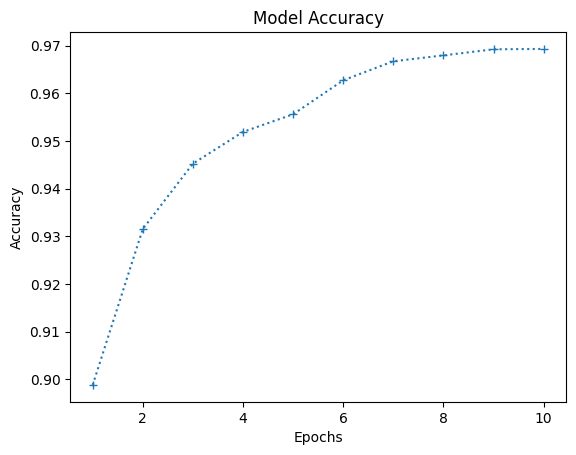

In [9]:
accuracy = []
train_loss = []
val_loss = []

if not conf["load_model"]:
    accuracy, train_loss, val_loss = train(model=model, train_loader=train_loader, val_loader=val_loader)
    plot_data(accuracy, type="Accuracy", title="Model Accuracy")

In [10]:
test_loss, test_acc = evaluate(model, test_loader)
print(f"Accuracy: {100*test_acc:.2f}%, Test loss: {test_loss:.4f}")

Accuracy: 96.94%, Test loss: 0.0986


In [11]:
def save_model(checkpoint_path, model, optimizer, scheduler):
    checkpoint = {
        "epoch": conf["epochs"],
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict()
    }

    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

In [12]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", "gru_model.pth")
save_model(checkpoint_path, model, optimizer, scheduler)

Checkpoint saved at /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/gru_model.pth
